# 1. Développement d'un jeu

In [43]:
# imports
import random
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# configuration
GAMMA = 0.96
ALPHA = 0.81

##### Créer une fonction qui permet de simuler le plateau en positionnant notamment les différents éléments (case départ, fin, dragons).

In [45]:
#for the space
"""
by default the default space is used
the space is a 2D array 4 * 4 of characters
the characters are: 
    'S' : the starting point
    '_' : empty space
    'J' : the goal
    'D' : a dragon
the default space is:
    S___
    D_D_ 
    ___D
    _D_J
"""

# the default space
default_space = [
        ['S', '_', '_', '_'],
        ['_', '_', 'D', '_'],
        ['D', '_', '_', 'D'],
        ['_', 'D', '_', 'J']
    ]

def get_default_space():
    return default_space

# a random space with number of lines and columns and a number of dragons
def get_random_space(lines, columns, dragons):
    space = []
    for l in range(lines):
        space.append([])
        for c in range(columns):
            space[l].append('_')

    space[0][0] = 'S'
    space[lines-1][columns-1] = 'J'
    
    i = 0
    while i < dragons:
        l = random.randint(0, lines-1)
        c = random.randint(0, columns-1)
        if space[l][c] == '_':
            space[l][c] = 'D'
            i += 1
        else:
            i -= 1

    return space

# pretty print the space
def print_space(space):
    for l in space:
        for c in l:
            print(c, end='| ')
        
        print()

# get the size of the lines
def get_lines_size(space):
    return len(space)

# get the size of the columns
def get_columns_size(space):
    return len(space[0])

# get the size of the space
def get_size(space):
    return get_lines_size(space) * get_columns_size(space)
    

In [46]:
# a static class for the rewards
class Rewards:
    # the rewards for each character
    rewards = {
        'S': 0,
        '_': 0,
        'J': 1,
        'D': -1
    }

    # a method to get the reward of a character
    def get_reward(character):
        return Rewards.rewards.get(character)

    # a method to set the reward 
    def set_rewards(rewards):
        Rewards.rewards = rewards

    # a method to set the reward of a character
    def set_reward(character, reward):
        Rewards.rewards[character] = reward

##### Créer une fonction qui permet de simuler l'interaction entre l'agent et son environnement.

In [47]:
# a static class for the Directions
class Directions:
    # the directions
    directions = ["HAUT", "DROITE", "BAS", "GAUCHE"]

    # a method to get the size of the directions
    def get_size():
        return len(Directions.directions)

    # a method to get the index of a direction
    def get_index(direction):
        return Directions.directions.index(direction)

    # a method to get a random direction
    def get_random_direction():
        return random.choice(Directions.directions)

    # a method to get the direction that maximizes the Q value
    def get_max_direction(mat_q, state):
        return Directions.directions[np.argmax(mat_q[state])]

In [48]:
def isFin (space, position, verbose = False):
    (l,c) = position

    # if the player is at the goal, back to the starting point
    if(space[l][c]== 'J'):
        # print in green win
        if verbose:
            print("\033[92m" + 
            "***********************************************************************************************************************************************************\n" +
            "********************************************************************** YOU WIN ****************************************************************************\n" +
            "***********************************************************************************************************************************************************\n" +
            "\033[0m")
        return True, (0,0)

    # # if the player ecnounters a dragon, back to the starting point
    if(space[l][c]== 'D'):
        # print in red loose
        if verbose:
            print("\033[91m" +
            "********************************************************************** YOU LOOSE ***************************************************************************\n" +
            "\033[0m")
        return True, (0,0)

    return False, position

# a method to apply an action to the player
def applicaion_action(action, position, space, verbose = False):

    (l, c) = position
    nextPos = position

    if action == "HAUT":
        nextPos = (l-1,c)
    elif action == "DROITE":
        nextPos = (l,c+1)
    elif action == "BAS":
        nextPos = (l+1,c);
    elif action == "GAUCHE":
        nextPos = (l,c-1);

    # check if the next position is in the space
    if (nextPos[0] < len(space) and nextPos[1] < len(space) and nextPos[0] >=0 and nextPos[1] >=0 ):
        position = nextPos
        
    # get the current case in the space
    case = space[position[0]][position[1]]
    # set the reward
    reward = Rewards.get_reward(case)

    # check if the player is at the goal
    fin, position = isFin(space, position, verbose)

    return [position, reward, fin]

### Donner quelques éléments de commentaire sur la mise en place de l'environnement de jeux

##### 1) Le plateau

Pour créer un environnement de jeux, nous avons d'abord créé une la variable ***default_space*** qui est un tableau 2 dimensions **(4*4)** de charactères qui representent les cases du plateau de jeu proposé. Les cases sont représentées par les caractères suivants:

*   **"_"** représente une case vide
*   **"D"** représente une case avec un dragon
*   **"S"** représente la case de départ
*   **"J"** représente la case d'arrivée (JAIL)


Nous avons aussi créé une fonction ***get_random_space*** qui permet de générer un plateau de jeu aléatoire en precisant le nombre de lignes, de colonnes etle nombre de dragons à placer sur le plateau.

Nous avons aussi créé une fonction ***print_space*** qui permet d'afficher le plateau de jeu.

##### 2) L'interaction

Avec la function ***application_action*** nous créons une nouvelle position ***nextPos*** en fonction de l'***action***, et nous verifions si la nouvelle position est valide ou non. 

Si la nouvelle position est valide, nous mettons à jour la position de l'agent et nous recupérons la récompense associée à cette nouvelle position.

Si la nouvelle position n'est pas valide, nous ne mettons pas à jour la position de l'agent et nous recupérons la récompense associée à la position actuelle.

Puis nous verifions si la partie est terminée ou non (si l'agent est arrivé à la case d'arrivée ou s'il tombé sur un dragon), si la partie est terminée, nous réinitialisons la position de l'agent à la case de départ.

# 2. Développement du Q-learning

In [49]:
# for the Q matrix
# init the Q matrix with zeros and the size of the space and the directions length
def init_mat_q(space):
    return np.zeros((get_lines_size(space), get_columns_size(space), Directions.get_size()))

# get the Q value of a state and a direction
def get_q_value(mat_q, state, direction):
    return mat_q[state][Directions.get_index(direction)]

# update the Q matrix
# according to state, action, reward, next_state, ALPHA and GAMMA
def update_mat_q(mat_q, state, action, reward, next_state):
    mat_q[state][Directions.get_index(action)] += ALPHA * (reward + GAMMA * np.max(mat_q[next_state]) - mat_q[state][Directions.get_index(action)])
    return mat_q

# pretty print the space
def print_mat_q(mat_q, space):
    def get_best_direction(l, c):
        return Directions.directions[np.argmax(mat_q[l][c])]

    for l in range(get_lines_size(space)):
        for c in range(get_columns_size(space)):
            case      = space[l][c]
            direction = get_best_direction(l, c)
            q_value   = str(round(get_q_value(mat_q, (l, c), direction), 2)).ljust(6)

            content = case + " (" + q_value + ") " + direction
            print(content.ljust(20), end='| ')
        print("\n_______________________________________________________________________________________")

In [50]:
# a class for the game
class Game:
    # constructor that takes :
    # number of episodes : 10000 by default
    # number of steps : 100 by default
    # is_random_space : False by default
    # a Q matrix : initialized with zeros (with the size of the space and the number of directions)
    def __init__(self, episodes = 10000, steps = 100, is_random_space = False, mat_q = None):
        self.episodes = episodes
        self.steps = steps
        # the space
        if is_random_space:
            self.space = get_random_space(4, 4, 3)
        else:
            self.space = get_default_space()
        
        # the Q matrix 
        if mat_q is None:
            self.mat_q = init_mat_q(self.space)

    # a method to choose an action with the epsilon greedy policy
    def choose_action(self, state, epsilon, mat_q):
        if random.random() < epsilon:
            return Directions.get_random_direction()
        else:
            return Directions.get_max_direction(mat_q, state)

    # a method to play one step (with mat_q, state, epsilon)
    def oneStep(self, mat_q, state, epsilon, verbose):
        # choose an action
        action = self.choose_action(state, epsilon, mat_q)
        if verbose:
            print(action, end=', ')
        # apply the action
        new_state, reward, fin = applicaion_action(action, state, self.space)
        # update the Q matrix
        new_q = update_mat_q(mat_q, state, action, reward, new_state)
        return new_q, new_state, fin

    # a method to apply the algorithm 
    def apply_algorithm(self):
        total_steps = 0
        # apply the algorithm 
        for episode in range(self.episodes):
            # reset the position
            position = (0, 0)
            # calculate the epsilon
            epsilon = self.episodes / (self.episodes + episode)
            #print("epsilon : ", epsilon)

            # play the game
            for step in range(1, self.steps):
                # play one step
                self.mat_q, position, fin = self.oneStep(self.mat_q, position, epsilon, False)
                # if the game is finished
                if fin:
                    total_steps += step
                    break

        print("total steps : ", total_steps)
        print("average steps : ", total_steps / self.episodes)

    # a method to play the game
    def play(self):
        # reset the position
        position = (0, 0)
        # play the game
        for step in range(1, self.steps):
            # play one step
            self.mat_q, position, fin = self.oneStep(self.mat_q, position, 0, True)
            # if the game is finished
            if fin:
                break


In [51]:
# PLAY
game = Game()
game.apply_algorithm()

total steps :  81170
average steps :  8.117


### Donner des éléments de commentaire sur la stratégie que vous avez utilisée pour développer l'algorithme de Q-Learning.

##### 1) La matrice Q

Nous avons :
*   Une function ***init_mat_q*** qui prend en paramètre le plateau de jeu et elle retourne la matrice Q ***(nombre de ligne * nombre de ligne * Nombre de directions)*** initialisée à 0.
*   Une function ***update_mat_q*** qui prend en paramètre la matrice Q, la position actuelle, la position suivante, l'action, la récompense et met à jour la matrice Q à la position actuelle et et pour la direction de l'action en utilisant la formule du cours.


##### 2) L'algorithme Q-learning

Nous avons une class ***Game***, son constructeur prend en paramètre :
*   Le nombre de parties à jouer (10000 par défaut)
*   Le nombre de coups par partie (100 par défaut)
*   Un booléen ***is_random_space*** (False par défaut) qui permet de choisir si on veut un plateau de jeu aléatoire ou celui proposé par défaut
*   Une matrice Q (None par défaut) qui permet de choisir si on veut utiliser une matrice Q déjà existante ou une nouvelle matrice Q qu'on va générer à partir du plateau de jeu

La stratégie utilisée est l'***epsilon-greedy***, on choisit une action aléatoire avec une probabilité ***epsilon***, sinon on choisit l'action qui maximise la récompense.

Dans la boucle pricipale de l'algorithme, l'epsilon est une fraction (nombre de parties  à jouer / nombre de parties  à jouer + nombre de parties jouées), donc au fur et à mesure que le nombre de parties jouées augmente, l'epsilon diminue.)

In [52]:
print(game.mat_q)

[[[3.603157   3.75328854 3.75328854 3.603157  ]
  [3.75328854 3.603157   3.90967556 3.603157  ]
  [3.603157   3.45903072 2.603157   3.75328854]
  [3.45903072 3.45903072 3.32066949 3.603157  ]]

 [[3.603157   3.90967556 2.603157   3.75328854]
  [3.75328854 2.603157   4.07257871 3.75328854]
  [0.         0.         0.         0.        ]
  [3.45903072 3.32066949 2.603157   2.603157  ]]

 [[0.         0.         0.         0.        ]
  [3.90967556 4.24226949 2.603157   2.603157  ]
  [2.603157   2.603157   4.41903072 4.07257871]
  [0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [4.24226949 4.603157   4.41903072 2.603157  ]
  [0.         0.         0.         0.        ]]]


In [53]:
# play a with the optimal policy
for step in range(1, game.steps):
    # play one step
    game.mat_q, position, fin = game.oneStep(game.mat_q, position, 0, True)
    if fin:
        print("fin de partie en", step, "coups")
        break

DROITE, BAS, BAS, DROITE, BAS, DROITE, fin de partie en 6 coups


In [54]:
print_mat_q(game.mat_q, game.space)

S (3.75  ) DROITE   | _ (3.91  ) BAS      | _ (3.75  ) GAUCHE   | _ (3.6   ) GAUCHE   | 
_______________________________________________________________________________________
_ (3.91  ) DROITE   | _ (4.07  ) BAS      | D (0.0   ) HAUT     | _ (3.46  ) HAUT     | 
_______________________________________________________________________________________
D (0.0   ) HAUT     | _ (4.24  ) DROITE   | _ (4.42  ) BAS      | D (0.0   ) HAUT     | 
_______________________________________________________________________________________
_ (0.0   ) HAUT     | D (0.0   ) HAUT     | _ (4.6   ) DROITE   | J (0.0   ) HAUT     | 
_______________________________________________________________________________________


#### Analyser la table obtenue, montrer par simulation que votre politique ainsi définie fonctionne

Dans la table obtenue, chaque ligne represente une case du plateau, une ligne est de la forme [recompense en allant en ***HAUT***, recompense en allant à ***GAUCHE***, recompense en allant en ***BAS***,  recompense en allant à ***DROITE***].

Nous pouvons voir que dans chaque ligne, la recompense maximale est associée à la direction qui permet de gagner la partie. Ce qui signifie que notre politique est correcte.

Notre simulation montre que notre politique fonctionne, car l'agent arrive à la case d'arrivée en 6 coups, ce qui est le nombre de coups minimum pour gagner la partie.

### Test avec différents paramètres

In [ ]:
def play_with_rewards(start_reward, dragon_reward, empty_reward, jail_reward):
    # set the rewards
    Rewards.set_rewards({"S": start_reward, "D": dragon_reward, "J": jail_reward, "_": empty_reward})

    # play
    game = Game()
    game.apply_algorithm()
    

# Deep Q-Learning

In [390]:
# IMPORTS
import tensorflow as tf
import sys

In [ ]:
# configuration
GAMMA = 0.999
ALPHA = 0.81

##### Test avec une structure 2 couches denses ayant 16 entrées (nombre de cases) et 4 sorties (4 actions)


In [397]:
# a class for the game
class DeepGame:
    # constructor that takes :
    # number of episodes : 10000 by default
    # number of steps : 100 by default
    # is_random_space : False by default
    # vec_etat : vector of states (for deep Q learning)
    # a model : CNN
    # the optimizer name
    # the loss function name
    # verbose : False by default
    def __init__(
        self, 
        episodes = 10000, 
        steps = 100, 
        is_random_space = False, 
        vec_etat = None, 
        model = None,
        optimizer_name = "Nadam",
        loss_fn_name = None,
        verbose = False
        ):

        self.episodes = episodes
        self.steps = steps
        self.vec_etat = vec_etat
        self.model = model
        self.optimizer_name = optimizer_name
        self.loss_fn_name = loss_fn_name
        self.verbose = verbose

        # the space
        if is_random_space:
            self.space = get_random_space(4, 4, 3)
        else:
            self.space = get_default_space()

        # the vector of states
        if vec_etat is None:
            self.set_default_vec_etat()

        # the model
        if model is None:
            self.set_default_model()

        # the optimizer
        self.set_optimizer(optimizer_name)

        # the loss function
        self.set_loss_fn(loss_fn_name)



    # a method to set the vector of states
    def set_vec_etat(self, vec_etat):
        self.vec_etat = vec_etat

    # a method to set the default vector of states
    def set_default_vec_etat(self):
        self.vec_etat = np.zeros((1, 16))
        self.vec_etat[0][0] = 1

    # a method to reset the vector of states
    def reset_vec_etat(self):
        self.vec_etat = np.zeros((1, 16))

    # a method to update the vector of states
    def update_vec_etat(self, state):
        self.reset_vec_etat()
        self.vec_etat[0, int(get_lines_size(self.space) * state[0] + state[1])] = 1

    # a method to set the model
    def set_model(self, model):
        self.model = model

    # a method to set the default model
    def set_default_model(self):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(4, activation='relu', input_shape=[16]),
            tf.keras.layers.Dense(4, activation='relu'),
            tf.keras.layers.Dense(4),
        ])

    # a method to save the model
    def save_model(self):

        # number of epochs
        E = "E_" + str(self.episodes)
        # number of steps
        S = "_S_" + str(self.steps)
        # optimizer
        O = "_O_" + str(self.optimizer_name)
        # loss function
        L = "_L_" + str(self.loss_fn_name)
        # dragon reward
        DR = "_DR_" + str(Rewards.rewards["D"])
        # empty reward
        ER = "_ER_" + str(Rewards.rewards["_"])
        # jail reward
        JR = "_JR_" + str(Rewards.rewards["J"])

        # file path
        path = "./seved_models/" + E + S + O + L + DR + ER + JR + ".h5"

        self.model.save(path)

    # a method to set the optimizer
    # optimizer_name : Nadam by default, SGD,Adam
    def set_optimizer(self, optimizer_name):
        # set the optimizer according to the name 
        if optimizer_name == "Adam":
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
        elif optimizer_name == "SGD":
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001)
        else:
            self.optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00001)

    # a method to set the loss function
    # loss_fn : MSE by default, MAE
    def set_loss_fn(self, loss_fn):
        # set the loss function according to the name
        if loss_fn == "MAE":
            self.loss_fn = tf.keras.losses.MAE
        else:
            self.loss_fn = tf.keras.losses.MSE

    # function to print if verbose
    def print(self, *args):
        if self.verbose:
            print(*args)

    # a method to show progress
    def show_progress(self, episode, step, is_random, action, current_case, reward, next_Q_max, target):
        choice = "  (random)  " if is_random else "  (predict) "

        self.print(
            "episode : " + str(episode).ljust(5) +
            "| step : " + str(step).ljust(5) +
            "| action : " + str(action).ljust(7) + choice +
            "| current_case : " + str(current_case).ljust(3) +
            "| reward : " + str(reward).ljust(5) +
            "| next_Q_max : " + str(next_Q_max).ljust(15) +
            "| target : " + str(target).ljust(15)
        )
        

    #####################################################################################################################


    # a method to choose an action with the epsilon greedy policy
    def choose_action(self, state, epsilon):
        is_random = np.random.uniform() < epsilon
        if is_random:
            action = Directions.get_random_direction()
        else:
            Sortie_Q = self.model(self.vec_etat)  # En entrée le vecteur symbolisant l'état
            action = Directions.directions[np.argmax(Sortie_Q)] #On sélectionne l'action associée avec la sortie max
        return action, is_random
     
    # Train the model
    def train(self):
        # create a stable model
        model_stable = tf.keras.models.clone_model(self.model)
        model_stable.set_weights(self.model.get_weights())

        history = np.zeros(self.episodes)

        for episode in range(self.episodes):
            print("ep :", episode)
            # reset the position
            position = (0, 0)
            # calculate the epsilon
            epsilon = self.episodes / (self.episodes + episode)
 


            # set the vector of states
            self.update_vec_etat(position)




            for step in range(self.steps):
                # play one step
                # choose an action
                action, is_random = self.choose_action(position, epsilon)
                # apply the action
                position, reward, fin = applicaion_action(action, position, self.space, self.verbose)
  
                if fin:
                    break

                # set weights of the stable model
                if step % 10 == 0:
                    model_stable.set_weights(self.model.get_weights())

                vec_etat_next = np.zeros((1, 16)) # ca sera l'entree du reseau
                vec_etat_next[0, int(get_lines_size(self.space) * position[0] + position[1])] = 1

                # model stable predict
                next_Q = model_stable.predict(vec_etat_next, verbose=0)
                next_Q_max = np.max(next_Q)

                # target
                target = reward + GAMMA * next_Q_max * (1 - fin)
                self.show_progress(episode, step, is_random, action, self.space[position[0]][position[1]], reward, next_Q_max, target)

                # gradient descent
                with tf.GradientTape() as tape:
                    predict = self.model(self.vec_etat) # ce que l'on pense obtenir
                    # get index of the action
                    action_index = Directions.get_index(action)
                    mask = tf.one_hot(action_index, Directions.get_size())
                    val_predict = tf.reduce_sum(predict * mask, axis=1)
                    loss = self.loss_fn(target, val_predict)

                gradients = tape.gradient(loss, self.model.trainable_variables) # calcul du gradient de la focntion loss en fonction des variables du modèle 
                self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables)) # optimisation des paramètres du modèle
                history[episode] = loss.numpy() # on récupère la valeur pour afficher l'évolution de l'erreur

                # update the vector of states
                self.update_vec_etat(position)

        plt.plot(history, color="red")
        plt.title("Evolution de l'erreur")
        plt.show()

        # save the model
        self.save_model()

    # play the game
    def play(self):

        iter = 0
        position = (0, 0)
        fin = False

        while iter < self.steps and not fin:
            iter += 1
            # update the vector of states
            self.update_vec_etat(position)
            # choose an action
            action, _ = self.choose_action(position, 0)
            # apply the action
            new_position, reward, fin = applicaion_action(action, position, self.space)

            print( str(position) + " " + str(action) + " " + str(new_position))
            if iter % 10 == 0:
                print()
            
            if fin:
                print("fin de partie en", iter, "coups")
                break
            # update the position
            position = new_position

        if iter == self.steps:
            print("Trop d'itérations")



In [392]:
# function to create a game with a configuration train and play
def create_game(optimizer_name, loss_fn_name, episodes, steps, dragon_reward, jail_reward, empty_reward, start_reward=-5, verbose=False):
    # set the rewards
    Rewards.set_rewards({"S": start_reward, "D": dragon_reward, "J": jail_reward, "_": empty_reward})
    # create the game
    game = DeepGame(episodes=episodes, steps=steps, optimizer_name=optimizer_name, loss_fn_name=loss_fn_name, verbose=verbose)

    game.train()
    game.play()

    return game

#### TEST


*   ***optimizer*** : Adam
*   ***loss function*** : SGD
*   ***epochs*** : 1000
*   ***steps*** : 100
*   ***Reward Dragon*** : -500
*   ***Reward Empty*** : -20
*   ***Reward Jail*** : 500



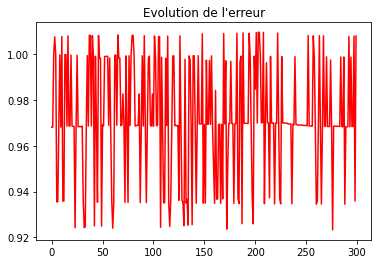

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) 

In [396]:
game1 = create_game(optimizer_name="Adam", loss_fn_name="SGD", episodes=300, steps=100, dragon_reward=-10, empty_reward=0, jail_reward=10, verbose=False)

#### TEST


*   ***optimizer*** : Nadam
*   ***loss function*** : MSE
*   ***epochs*** : 5000
*   ***steps*** : 100
*   ***Reward Dragon*** : -100
*   ***Reward Empty*** : -10
*   ***Reward Jail*** : 1000



ep : 0
ep : 1
ep : 2
ep : 3
ep : 4
ep : 5
ep : 6
ep : 7
ep : 8
ep : 9
ep : 10
ep : 11
ep : 12
ep : 13
ep : 14
ep : 15
ep : 16
ep : 17
ep : 18
ep : 19
ep : 20
ep : 21
ep : 22
ep : 23
ep : 24
ep : 25
ep : 26
ep : 27
ep : 28
ep : 29
ep : 30
ep : 31
ep : 32
ep : 33
ep : 34
ep : 35
ep : 36
ep : 37
ep : 38
ep : 39
ep : 40
ep : 41
ep : 42
ep : 43
ep : 44
ep : 45
ep : 46
ep : 47
ep : 48
ep : 49
ep : 50
ep : 51
ep : 52
ep : 53
ep : 54
ep : 55
ep : 56
ep : 57
ep : 58
ep : 59
ep : 60
ep : 61
ep : 62
ep : 63
ep : 64
ep : 65
ep : 66
ep : 67
ep : 68
ep : 69
ep : 70
ep : 71
ep : 72
ep : 73
ep : 74
ep : 75
ep : 76
ep : 77
ep : 78
ep : 79
ep : 80
ep : 81
ep : 82
ep : 83
ep : 84
ep : 85
ep : 86
ep : 87
ep : 88
ep : 89
ep : 90
ep : 91
ep : 92
ep : 93
ep : 94
ep : 95
ep : 96
ep : 97
ep : 98
ep : 99
ep : 100
ep : 101
ep : 102
ep : 103
ep : 104
ep : 105
ep : 106
ep : 107
ep : 108
ep : 109
ep : 110
ep : 111
ep : 112
ep : 113
ep : 114
ep : 115
ep : 116
ep : 117
ep : 118
ep : 119
ep : 120
ep : 121
ep : 122
ep 

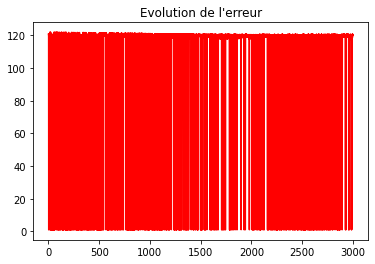

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)

(0, 0) HAUT (0, 0)
(0, 0) HAUT (0, 0)
(0, 0) 

In [398]:
game2 = create_game(optimizer_name="Nadam", loss_fn_name="MSE", episodes=3000, steps=100, dragon_reward=-100, empty_reward=-10, jail_reward=1000)